In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import glob
#%matplotlib widget
import datetime

For best results, run this script in notebook or widget mode (see https://github.com/matplotlib/ipympl )

In [2]:
%matplotlib notebook

In [3]:
# ATL15 stores time in a format that is not at all confusing.  
def to_decimal_years(t):
    t0=datetime.datetime.fromisoformat('2018-01-01T00:00:00.000000')
    return (t-np.datetime64(t0)).astype(float)/24./3600./365.25/1.e9 + 2018
def from_decimal_years(y):
    t0=datetime.datetime.fromisoformat('2018-01-01T00:00:00.000000')
    return np.datetime64(t0)+np.int64(y*24*3600*365.25*1.e9)

### Preparation:

You'll need to download the ATL15 file, and put it somwhere on your local disk, then point to it here:

In [4]:
nc_file='/Volumes/ice3/ben/ATL14/AA/ATL15_AA_0311_01km_001_01.nc'

## What's in an ATL15 file?

Each ATL15 file contains height difference (delta_h) and height-change-rate (dhdt) fields, in separate groups.  We can use the h5ls utility to look at the file structure:

In [5]:
! h5ls {nc_file}; echo "__delta_h__"; h5ls {nc_file}/delta_h; echo "__dhdt___";h5ls {nc_file}/dhdt_lag1;


METADATA                 Group
delta_h                  Group
dhdt_lag1                Group
dhdt_lag4                Group
dhdt_lag8                Group
orbit_info               Group
quality_assessment       Group
tile_stats               Group
__delta_h__
Polar_Stereographic      Dataset {SCALAR}
cell_area                Dataset {4521, 5521}
data_count               Dataset {12, 4521, 5521}
delta_h                  Dataset {12, 4521, 5521}
delta_h_sigma            Dataset {12, 4521, 5521}
ice_mask                 Dataset {4521, 5521}
misfit_rms               Dataset {12, 4521, 5521}
misfit_scaled_rms        Dataset {12, 4521, 5521}
time                     Dataset {12}
x                        Dataset {5521}
y                        Dataset {4521}
__dhdt___
Polar_Stereographic      Dataset {SCALAR}
dhdt                     Dataset {11, 4521, 5521}
dhdt_sigma               Dataset {11, 4521, 5521}
time                     Dataset {11}
x                        Dataset {5521}
y       

## Three ways to open an ATL15 file
There are a lot of ways to get access to the data in an ATL15 file. I'm going to demonstrate three of them:

-- h5py : this is a set of code that's easily available, and fairly simple to use.  Since netcdfs are just hdf5 files with some added perks, it will open and read them without a lot of fuss.

-- xarray: This is a more powerful set of code for opening datafiles and interacting with the contents.  It handles memory better than h5py, but, in my opinion, presents the data in a way that can be hard to understand

-- pointCollection: this is my library that wraps h5py/netCDF to make objects that are easy to use for common altimetry tasks.

## Reading the data with h5py:

With h5py, we're just going to read a list of fields, and save the results in a dictionary.  This is fairly standard python code:

In [6]:
import h5py

group='dhdt_lag8'
fields=['x','y','time','dhdt']
D_h5={}
with h5py.File(nc_file,'r') as h5f:
    for field in fields:
       D_h5[field]=np.array(h5f[group][field]) 


In [7]:
D_h5

{'x': array([-2720000., -2719000., -2718000., ...,  2798000.,  2799000.,
         2800000.]),
 'y': array([-2200000., -2199000., -2198000., ...,  2318000.,  2319000.,
         2320000.]),
 'time': array([639.1875, 730.5   , 821.8125, 913.125 ]),
 'dhdt': array([[[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...,
          3.4028235e+38, 3.4028235e+38, 3.4028235e+38],
         [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...,
          3.4028235e+38, 3.4028235e+38, 3.4028235e+38],
         [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...,
          3.4028235e+38, 3.4028235e+38, 3.4028235e+38],
         ...,
         [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...,
          3.4028235e+38, 3.4028235e+38, 3.4028235e+38],
         [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...,
          3.4028235e+38, 3.4028235e+38, 3.4028235e+38],
         [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ...,
          3.4028235e+38, 3.4028235e+38, 3.4028235e+38]],
 
        [[3.4028235e+38, 3.402823

Notice that a lot of the fields values look like 3.4028235e+38. This is the nodata value for the dhdt variable.  We can fix that manually.  While we're at it, we'll convert the 'time' field to a 'year' field:

In [8]:
for field in fields: 
    D_h5[field][np.abs(D_h5[field]>1.e16)]=np.NaN

D_h5['year'] = 2018+D_h5['time']/365.25
# and a nominal year field (rounded to the nearest quarter)
D_h5['year_r'] = np.round(D_h5['year']/0.25)*0.25

### Visualizing the data:
To put the data on screen, we need to compute the _extent_ of the data.  The extent runs from the left hand side of the first pixel to the right hand side of the last pixel, likewise for the top and bottom.



<IPython.core.display.Javascript object>


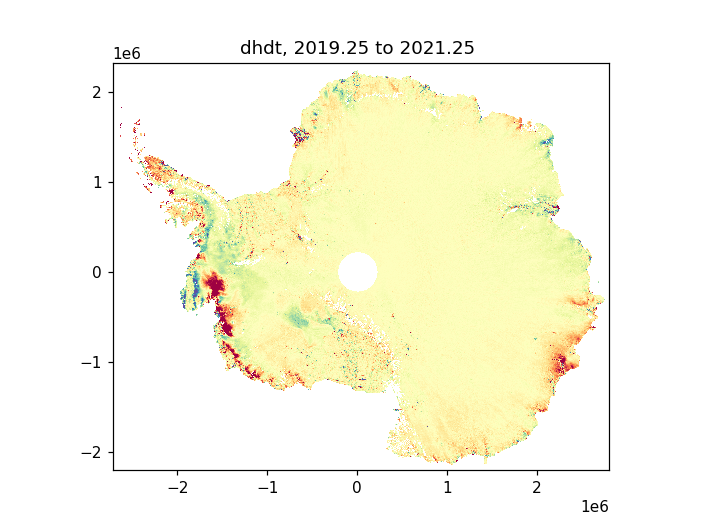

Text(0.5, 1.0, 'dhdt, 2019.25 to 2021.25 ')

In [9]:
dx=D_h5['x'][1]-D_h5['x'][0]
D_h5['extent']=[D_h5['x'][0]-dx/2, D_h5['x'][-1]+dx/2, D_h5['y'][0]-dx/2, D_h5['y'][-1]+dx/2]

plt.figure()
plt.imshow(D_h5['dhdt'][2,:,:], clim=[-1, 1], extent=D_h5['extent'], 
           origin='lower', cmap='Spectral', interpolation='nearest')
plt.title(f'dhdt, {D_h5["year_r"][2]-1} to {D_h5["year_r"][2]+1} ')

# Reading the data with Xarray:

In [10]:
import xarray as xr
xrd=xr.open_dataset(nc_file, group='dhdt_lag8')

In [11]:
## Select band 2 of dhdt:

In [12]:
dhdt=xrd.isel(time=2)

<IPython.core.display.Javascript object>


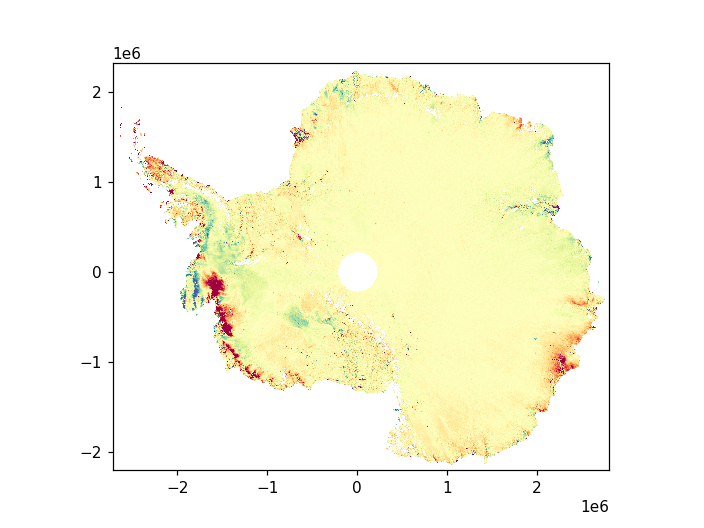

In [13]:
extent=[dhdt.x[0]-500, dhdt.x[-1]+500, dhdt.y[0]-500, dhdt.y[-1]+500]
plt.figure(); 
plt.imshow(np.array(dhdt.dhdt), extent=extent, origin='lower', cmap='Spectral', vmin=-1, vmax=1, interpolation='nearest')

In [14]:
xrd.close()

## Reading the data with pointCollection
pointCollection is a library of functions and classes designed to do many of the same things as xarray, but makes fewer modifications to the look and feel of the data: fields such as time maintain the units that they have in the files, and the attributes of data structures are just numpy arrays stored in memory.  It's not as suitable as xarray for reading and writing very large files, but it can often be simpler to work with.


In [15]:
import pointCollection as pc

# read the data, and turn it into a pc.data() instance.  Need to specify that the time axis is axis 0
D_pc = pc.grid.data(t_axis=0).from_nc(nc_file, group='dhdt_lag8', fields=['dhdt', 'dhdt_sigma', 'data_count'])

# pc.grid.data objects have both 't' and 'time' attributes.  
# The 't' attribute contains time in h5-native units (days since 2018.0), so we will
# store time in years in the 'time' attribute:
D_pc.time=2018+D_pc.t/365.25

print(D_pc)



<class 'pointCollection.grid.data.data'> with shape (4, 4521, 5521),
with fields:
['dhdt', 'dhdt_sigma']


We can visualize the dhdt map using the pc.data object's __show__ method:

<IPython.core.display.Javascript object>


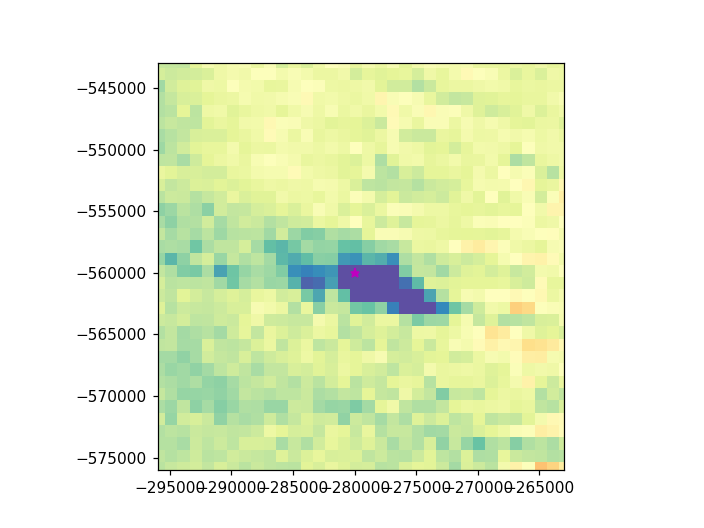

In [16]:
plt.figure()
D_pc.show(field='dhdt', band=2, cmap='Spectral', clim=[-1, 1], interpolation='nearest')

# save the handle to the current axes:
zoomed_map=plt.gca()

# this is just a shortcut to:
# plt.imshow(D_pc.dhdt[2,:,:], extent=D_pc.extent, origin='lower',  cmap='Spectral', clim=[-1, 1], interpolation='nearest')


### reading a subset of the delta_h data with pointCollection

Use the map to zoom into a small area, or just run the next cell:

In [17]:
zoomed_map.set_xlim([-296000.0, -263000.0])
zoomed_map.set_ylim([-576000.0, -543000.0])

(-576000.0, -543000.0)

Read the subset of the delta_h data that corresponds to the map extent:

In [18]:
D_dh = pc.grid.data(t_axis=0).from_nc(nc_file, group='delta_h', bounds=[zoomed_map.get_xlim(), zoomed_map.get_ylim()])

In [19]:
D_dh

<class 'pointCollection.grid.data.data'> with shape (12, 33, 33),
with fields:
['cell_area', 'delta_h', 'delta_h_sigma', 'ice_mask', 'data_count', 'misfit_rms', 'misfit_scaled_rms']

Now we can plot the time series at the center of the map:

<IPython.core.display.Javascript object>


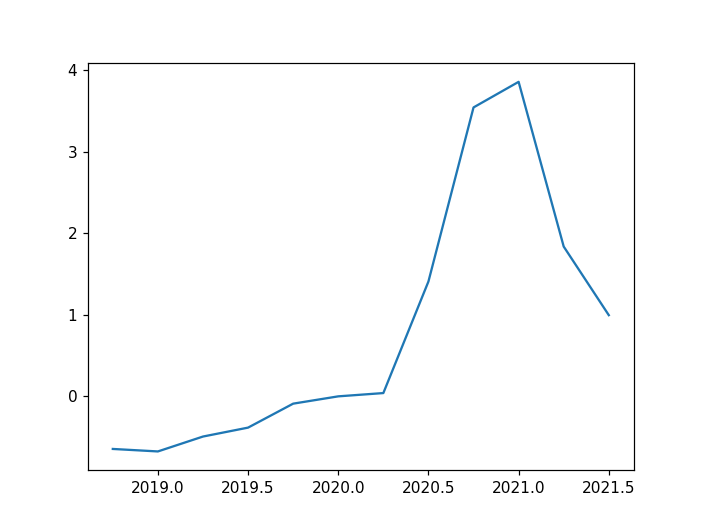

In [20]:
row=int(np.round(D_dh.shape[1]/2))
col=int(np.round(D_dh.shape[2]/2))
plt.figure(); plt.plot(D_dh.t/365.25+2018, D_dh.delta_h[:, row, col])

# plot the location for which we've generated this plot on the zooomed-in map of Antarctica
zoomed_map.plot(D_dh.x[col], D_dh.y[row], 'm*')


## Other useful fields:

Another useful map is the 'data_count' field, which shows which grid cells are constrained by one or more data.  If we display the fields in two subplots, and use the 'sharex' and 'sharey' keywords, we will be able to zoom the two images at the same time.

<IPython.core.display.Javascript object>


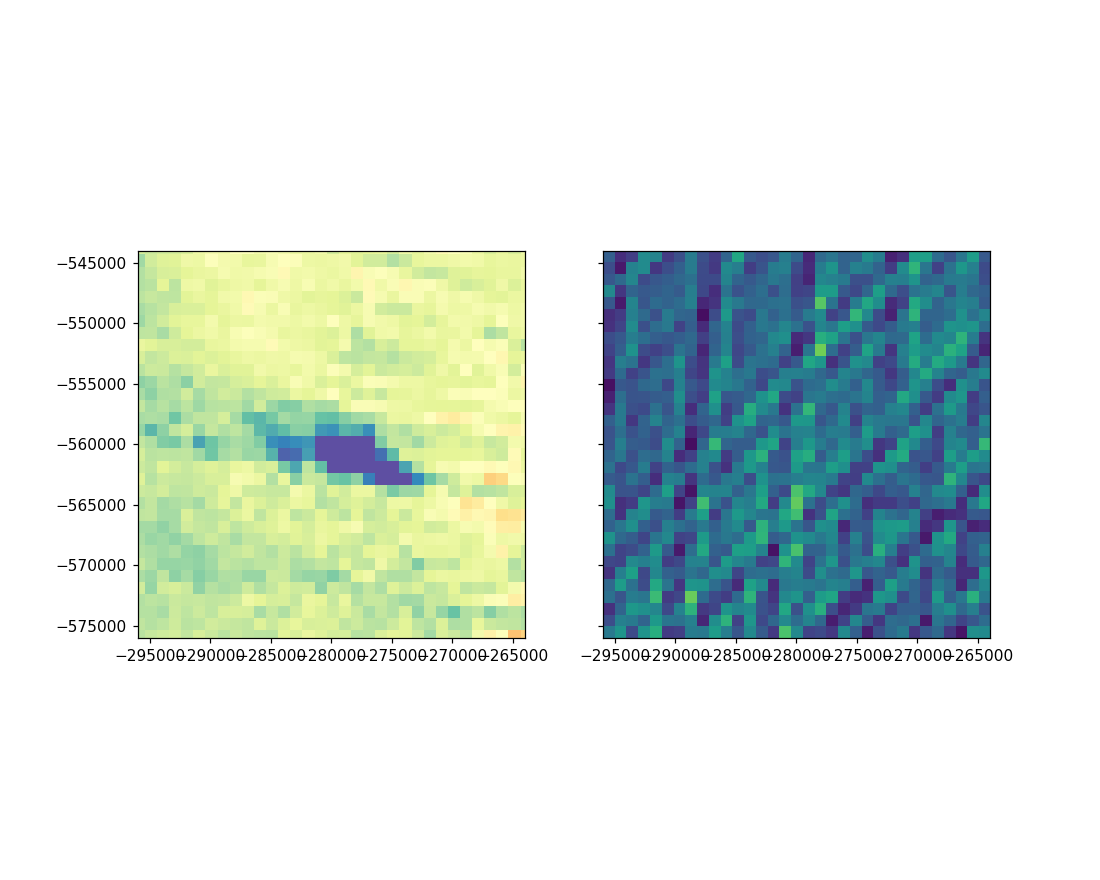

In [21]:
hf, ha=plt.subplots(1,2, figsize=[10, 8], sharex=True, sharey=True)

this_band=2
D_pc.show(field='dhdt', band=this_band, cmap='Spectral', clim=[-1, 1], interpolation='nearest', ax=ha[0])


D_dh.show( clim=[0, 50], field='data_count', band=this_band, \
          interpolation='nearest', ax=ha[1])

